# ONNXruntime with CUDA

* Cuda Version: 10.2
* onnxruntime-gpu==1.6: https://elinux.org/Jetson_Zoo#ONNX_Runtime
* Multipose Model: https://tfhub.dev/google/movenet/multipose/lightning/1
* Converted to Onnx via: 
```
!python3.6 -m tf2onnx.convert --saved-model ~/Downloads/movenet_multipose_lightning_1 --output pose-model.onnx
```

* Single Pose model: https://tfhub.dev/google/movenet/singlepose/lightning/4

In [1]:
import onnxruntime as ort
print(ort.get_available_providers())
print(ort.get_device())
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

WIDTH = 192
HEIGHT = 192
CONFIDENCE_THRESHOLD = 0.25

['CPUExecutionProvider', 'CUDAExecutionProvider']
GPU


In [2]:
# [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]
#   0       1          2          3        4           5               6              7           8            9          10            11          12      13          14         15           16
EDGES = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (5, 6),
    (5, 7),
    (6, 8),
    (7, 9),
    (8, 10),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (12, 14),
    (13, 15),
    (14, 16)
]

In [5]:
ort_session = ort.InferenceSession('movenet_singlepose_lightning_4.onnx')

# warmup:
s = time.time()
ort_session.run(
    None,
    {"input": np.random.randint(255, size=(1, HEIGHT, WIDTH, 3), dtype=np.int32)},
)
print('Warmup duration:', time.time() - s, 'sec')

Warmup duration: 6.558035612106323 sec


In [6]:
def infer(frame):
    return ort_session.run(
        None,
        {"input": frame},
    )[0][0]

In [7]:
def draw_keypoints(img, pose_keypoints):
    img = img.copy()
    y, x, _ = img.shape
    shaped_keypoints = np.squeeze(np.multiply(pose_keypoints, [y,x,1]))

    for (e1, e2) in EDGES:
        y1, x1, c1 = shaped_keypoints[e1]
        y2, x2, c2 = shaped_keypoints[e2]
        if min(c1, c2) >= CONFIDENCE_THRESHOLD:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 1)
    
    return img

In [44]:
def prepare_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    crop_size = min(frame.shape[:-1])
    x = int(frame.shape[1] / 2 - crop_size / 2)
    y = int(frame.shape[0] / 2 - crop_size / 2)
    frame = frame[y:y+crop_size, x:x+crop_size]
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    frame = np.reshape(frame, (1, HEIGHT, WIDTH, 3))
    frame = frame.astype(np.int32)
    
    return frame

In [94]:
cap = cv2.VideoCapture(0)

frames = []

for i in range(500):
    _, frame = cap.read()
    frame = prepare_frame(frame)

    s = time.time()
    pose_keypoints = infer(frame)
    print(i, ':', time.time() - s, 'sec')
    
    frame = draw_keypoints(frame[0], pose_keypoints)
    
    frames.append(frame)

0 : 0.09200310707092285 sec
1 : 0.05861639976501465 sec
2 : 0.0503695011138916 sec
3 : 0.05000805854797363 sec
4 : 0.04680800437927246 sec
5 : 0.04418325424194336 sec
6 : 0.04390406608581543 sec
7 : 0.04449009895324707 sec
8 : 0.044042110443115234 sec
9 : 0.044022321701049805 sec
10 : 0.043218374252319336 sec
11 : 0.039992570877075195 sec
12 : 0.03990292549133301 sec
13 : 0.039441585540771484 sec
14 : 0.03973388671875 sec
15 : 0.03985190391540527 sec
16 : 0.040402889251708984 sec
17 : 0.03977251052856445 sec
18 : 0.0400540828704834 sec
19 : 0.04042935371398926 sec
20 : 0.039818763732910156 sec
21 : 0.0400395393371582 sec
22 : 0.04047727584838867 sec
23 : 0.03985738754272461 sec
24 : 0.03986024856567383 sec
25 : 0.04049086570739746 sec
26 : 0.03980231285095215 sec
27 : 0.0399322509765625 sec
28 : 0.04037642478942871 sec
29 : 0.03992438316345215 sec
30 : 0.039789438247680664 sec
31 : 0.039386749267578125 sec
32 : 0.03346419334411621 sec
33 : 0.03323054313659668 sec
34 : 0.034447908401489

In [95]:
cap.release()
del cap

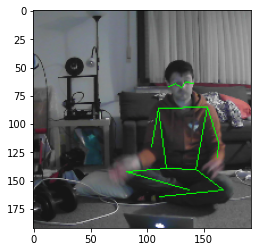

In [96]:
import matplotlib.animation as animation

fig = plt.figure()
plt.imshow(frames[0])
frame_plots = [ [plt.imshow(frame, animated=True)] for frame in frames ]

ani = animation.ArtistAnimation(fig, frame_plots, interval=50, blit=True, repeat_delay=1000)

plt.show()